In [1]:
pip install pyelastica

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np

# Import modules
from elastica.modules import BaseSystemCollection, Constraints, Forcing, Damping

# Import Cosserat Rod Class
from elastica.rod.cosserat_rod import CosseratRod

# Import Damping Class
from elastica.dissipation import AnalyticalLinearDamper

# Import Boundary Condition Classes
from elastica.boundary_conditions import OneEndFixedRod, FreeRod
from elastica.external_forces import EndpointForces, UniformForces

# Import Timestepping Functions
from elastica.timestepper.symplectic_steppers import PositionVerlet
from elastica.timestepper import integrate


In [3]:
pip show pyelastica

Name: pyelastica
Version: 0.3.2
Summary: Elastica is a software to simulate the dynamics of filaments that, at every cross-section, can undergo all six possible modes of deformation, allowing the filament to bend, twist, stretch and shear, while interacting with complex environments via muscular activity, surface contact, friction and hydrodynamics.
Home-page: https://www.cosseratrods.org/
Author: GazzolaLab
Author-email: armant2@illinois.edu
Note: you may need to restart the kernel to use updated packages.
License: MIT
Location: c:\users\jasonlaptop\anaconda3\envs\elastica-env\lib\site-packages
Requires: matplotlib, numba, numpy, pyvista, scipy, tqdm
Required-by: 


In [4]:
pip show numpy

Name: numpy
Version: 1.24.4
Summary: Fundamental package for array computing in Python
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD-3-Clause
Location: c:\users\jasonlaptop\anaconda3\envs\elastica-env\lib\site-packages
Requires: 
Required-by: contourpy, matplotlib, numba, pyelastica, pyvista, scipy
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip show matplotlib

Name: matplotlib
Version: 3.10.3
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: Unknown <matplotlib-users@python.org>
License: License agreement for matplotlib versions 1.3.0 and later
         
         1. This LICENSE AGREEMENT is between the Matplotlib Development Team
         ("MDT"), and the Individual or Organization ("Licensee") accessing and
         otherwise using matplotlib software in source or binary form and its
         associated documentation.
         
         2. Subject to the terms and conditions of this License Agreement, MDT
         hereby grants Licensee a nonexclusive, royalty-free, world-wide license
         to reproduce, analyze, test, perform and/or display publicly, prepare
         derivative works, distribute, and otherwise use matplotlib
         alone or in any derivative version, provided, however, that MDT's
         License Agreement and MDT's notice of copyright, i.e., "

In [206]:
class SingleSectionSimulator(BaseSystemCollection, Constraints, Forcing, Damping):
    pass


SSsim = SingleSectionSimulator()

In [207]:
#setting up parameters
n_elem = 100
#density = 1000
density = 7800     # kg/m^3
nu = 1e-4     #poisson ratio
#E = 1e6     #Young's modulus
E = 207e9
G = E / (nu + 1.0)     #shear modulues

start = np.zeros((3,))
direction = np.array([0.0, 0.0, 1.0])
normal = np.array([0.0, 1.0, 0.0])
#base_length = 3.0
base_length = 0.4
#base_radius = 0.25
base_radius = 0.001
base_area = np.pi * base_radius ** 2

In [208]:
#Create Rod
rod = CosseratRod.straight_rod(
    n_elem,
    start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    youngs_modulus=E,
    shear_modulus=G,
)

SSsim.append(rod)

In [209]:
#adding damping
dl = base_length / n_elem
dt = 0.01 * dl
SSsim.dampen(rod).using(
    AnalyticalLinearDamper,
    damping_constant=nu,
    time_step=dt,
)

In [210]:
#Boundary Conditions
SSsim.constrain(rod).using(
    OneEndFixedRod, constrained_position_idx=(0,), constrained_director_idx=(0,)
)

In [211]:
print("one end of the rod is fixed")

one end of the rod is fixed


In [212]:
#apply forces
uniform_force = np.array([-10.0, 0.0, 0.0])

SSsim.add_forcing_to(rod).using(
    UniformForces, force=uniform_force
)
print("Uniform Forces Added")

Uniform Forces Added


In [213]:
#The above are codes for single section cable driven CR motion-----------
#The following will extend the previous work into a double section one

In [214]:
base_radius2 = 0.0009

In [215]:
second_start = rod.position_collection[:, -1]
direction = (
    rod.position_collection[:, -1] - rod.position_collection[:, -2]
)
direction /= np.linalg.norm(direction)
normal = rod.director_collection[1, :, -1]

rod2 = CosseratRod.straight_rod(
    n_elements=n_elem,
    start=second_start,
    direction=direction,
    normal=normal,
    base_length=base_length,
    base_radius=base_radius2,
    density=density,
    youngs_modulus=E,
    shear_modulus=G,
)
SSsim.append(rod2)
SSsim.dampen(rod2).using(AnalyticalLinearDamper, damping_constant=nu, time_step=dt)

In [216]:
SSsim.add_forcing_to(rod2).using(UniformForces, force=uniform_force)

In [217]:
print('rod2 created with one end fixed to the free moving end of rod 1')

rod2 created with one end fixed to the free moving end of rod 1


In [218]:
SSsim.finalize()
print("system finalized!!!!!!!!!!")

system finalized!!!!!!!!!!


In [219]:
#Define simulation time
final_time = 10.0
total_steps = int(final_time / dt)
print("Total steps to take", total_steps)

timestepper = PositionVerlet()

Total steps to take 249999


In [220]:
#Run simulation
integrate(timestepper, SSsim, final_time, total_steps)

100%|██████████| 249999/249999 [01:12<00:00, 3456.78it/s]

Final time of simulation is :  10.00000000001872


10.00000000001872

In [221]:
#Post processing
def analytical_result(arg_rod, arg_uniform_force, n_elem=500):
    base_length = np.sum(arg_rod.rest_lengths)
    arg_s = np.linspace(0.0, base_length, n_elem)

    if type(arg_uniform_force) is np.ndarray:
        acting_force = arg_uniform_force[np.nonzero(arg_uniform_force)]
    else:
        acting_force = arg_uniform_force
    
    acting_force = np.abs(acting_force)
    
    linear_prefactor = -acting_force / arg_rod.shear_matrix[0, 0, 0]
    quadratic_prefactor = (
        -acting_force
        / 2.0
        * np.sum(arg_rod.rest_lengths / arg_rod.bend_matrix[0, 0, 0])
    )
    cubic_prefactor = (acting_force / 6.0) / arg_rod.bend_matrix[0, 0, 0]
    return (
        arg_s,
        arg_s * linear_prefactor
        + arg_s ** 2 * quadratic_prefactor
        + arg_s ** 3 * cubic_prefactor,
    )

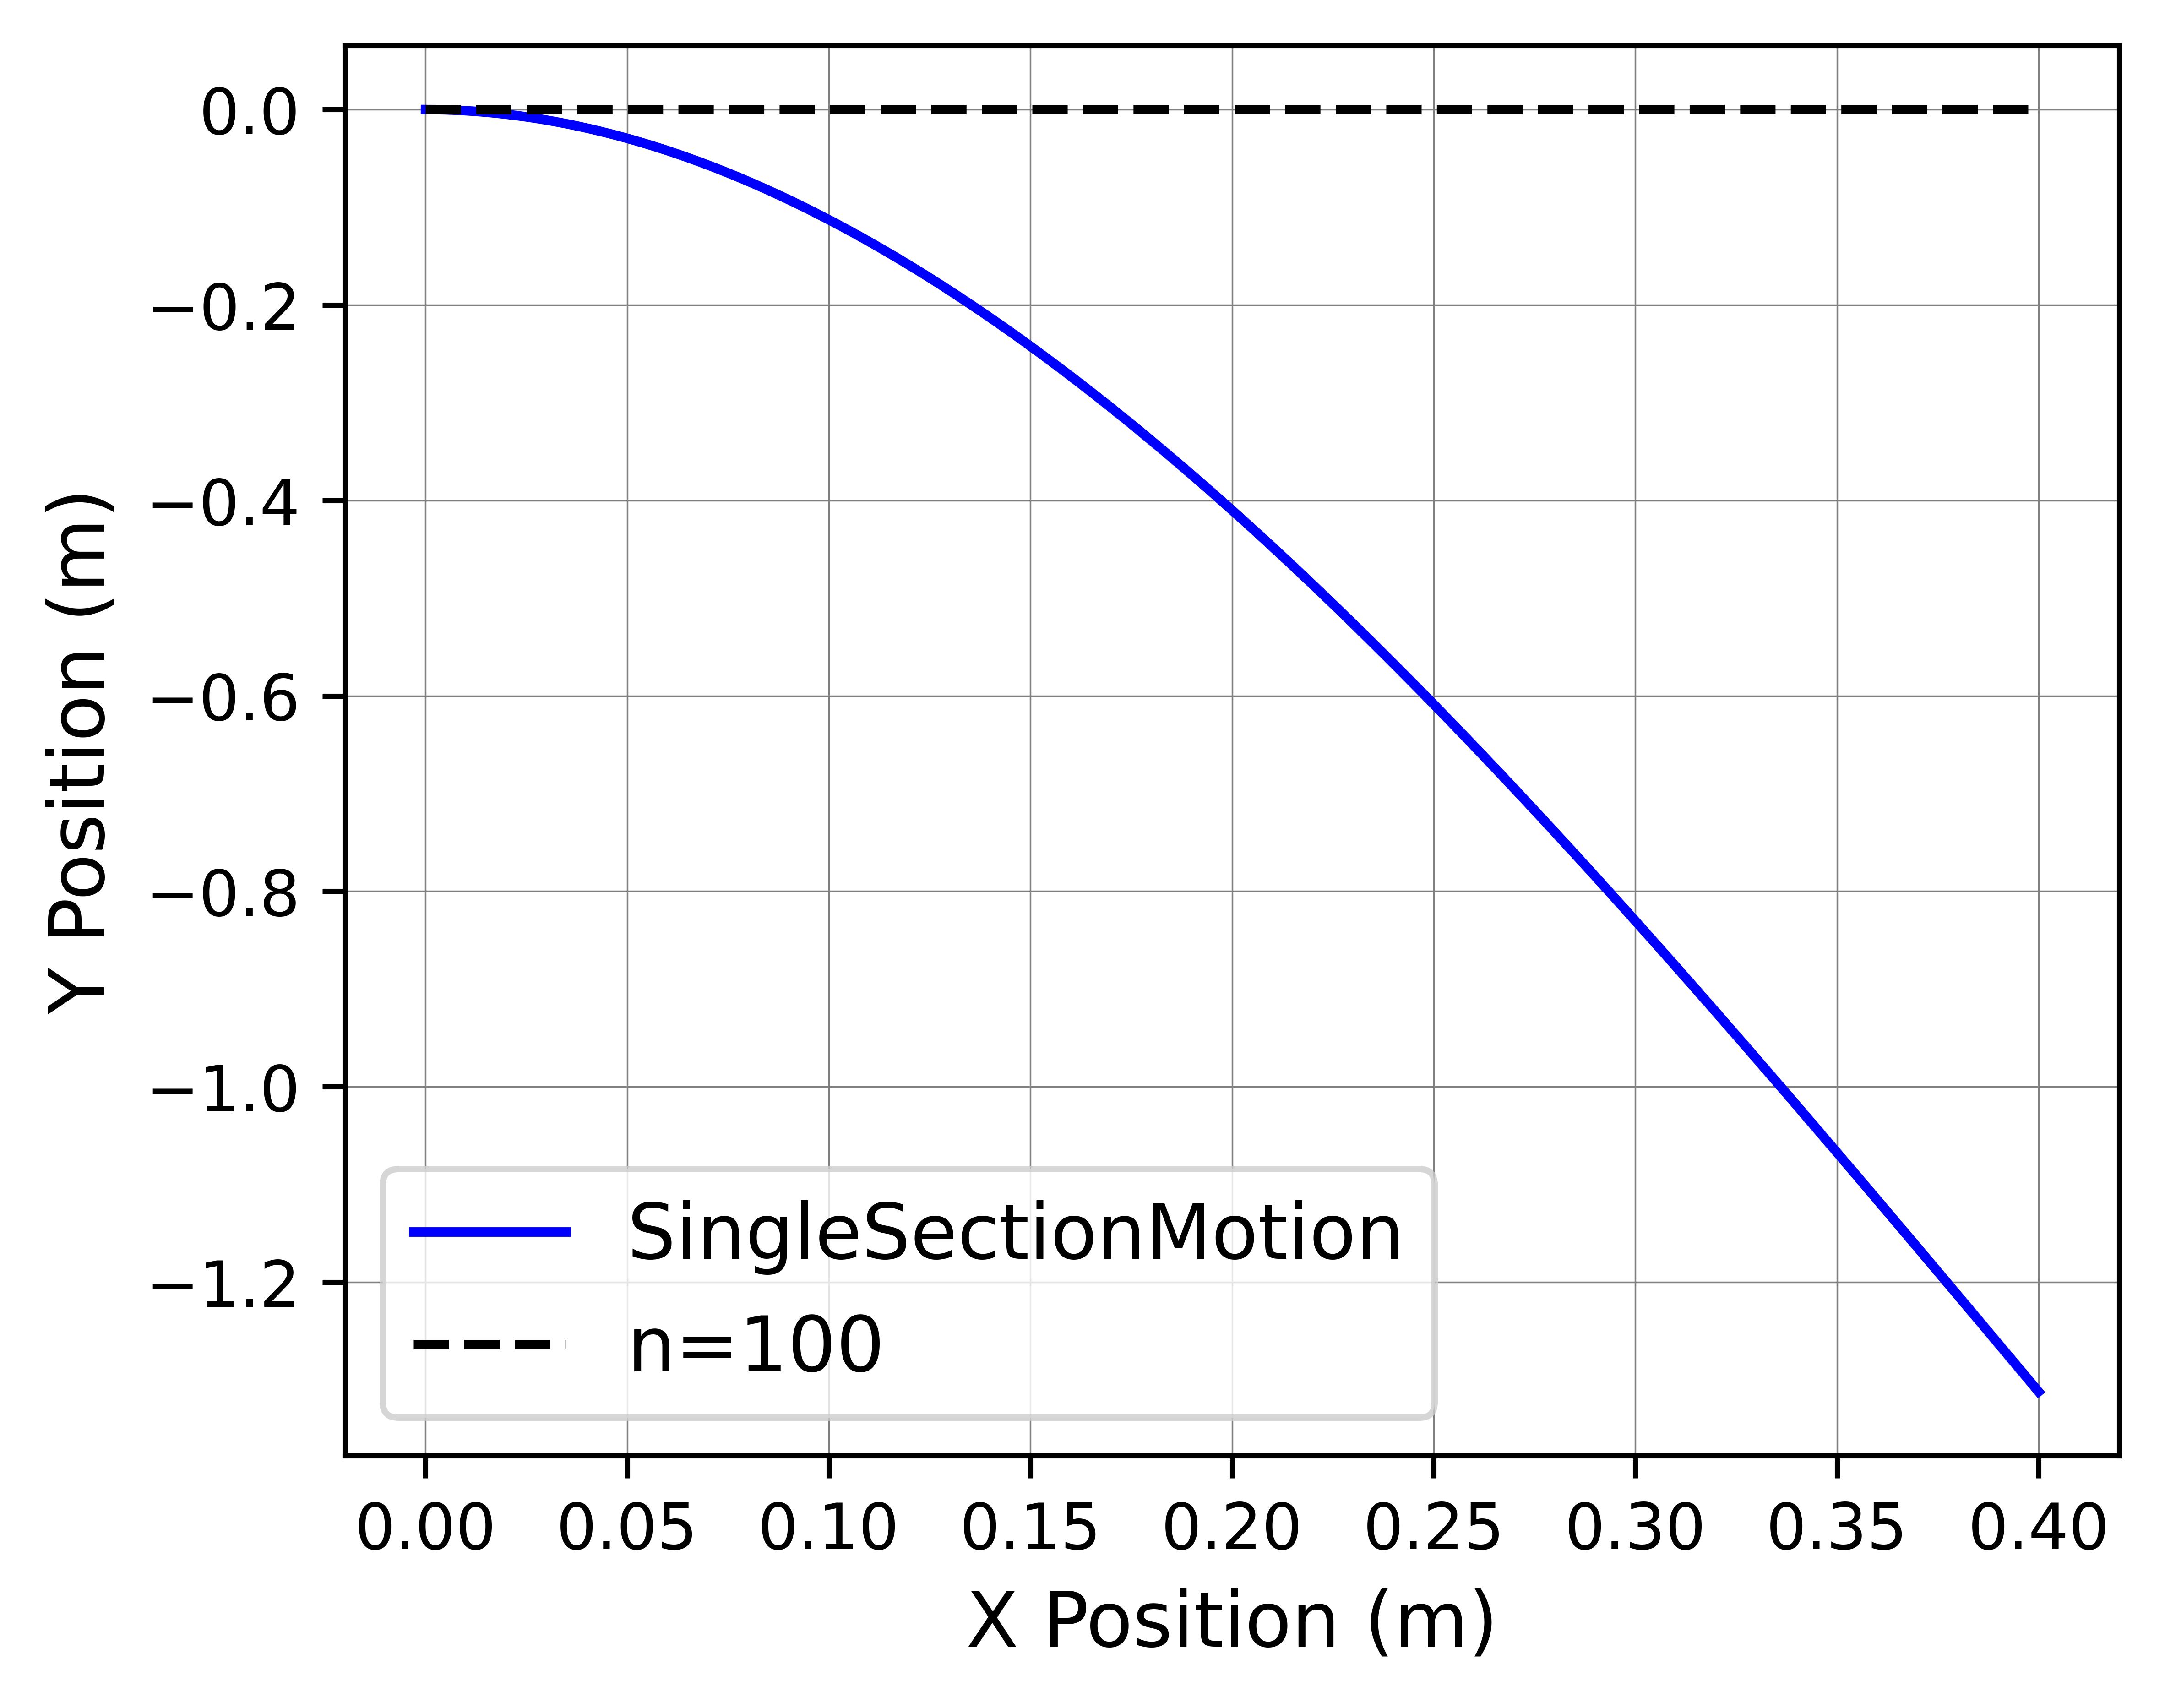

In [222]:
#Plotting Single Section
def plot_SS(rod, uniform_force):
    import matplotlib.pyplot as plt

    rod_position = analytical_result(
        rod, uniform_force
    )

    fig = plt.figure(figsize=(5,4), frameon=True, dpi = 1000)
    ax = fig.add_subplot(111)
    ax.grid(which="major", color="grey", linestyle="-", linewidth=0.25)

    ax.plot(
        rod_position[0],
        rod_position[1],
        "b-",
        label="SingleSectionMotion",
    )

    ax.plot(
        rod.position_collection[2, :],
        rod.position_collection[0, :],
        "k--",
        label="n=" + str(rod.n_elems),
    )

    ax.legend(prop={"size": 12})
    ax.set_ylabel("Y Position (m)", fontsize=12)
    ax.set_xlabel("X Position (m)", fontsize=12)
    plt.show()

plot_SS(rod, uniform_force)

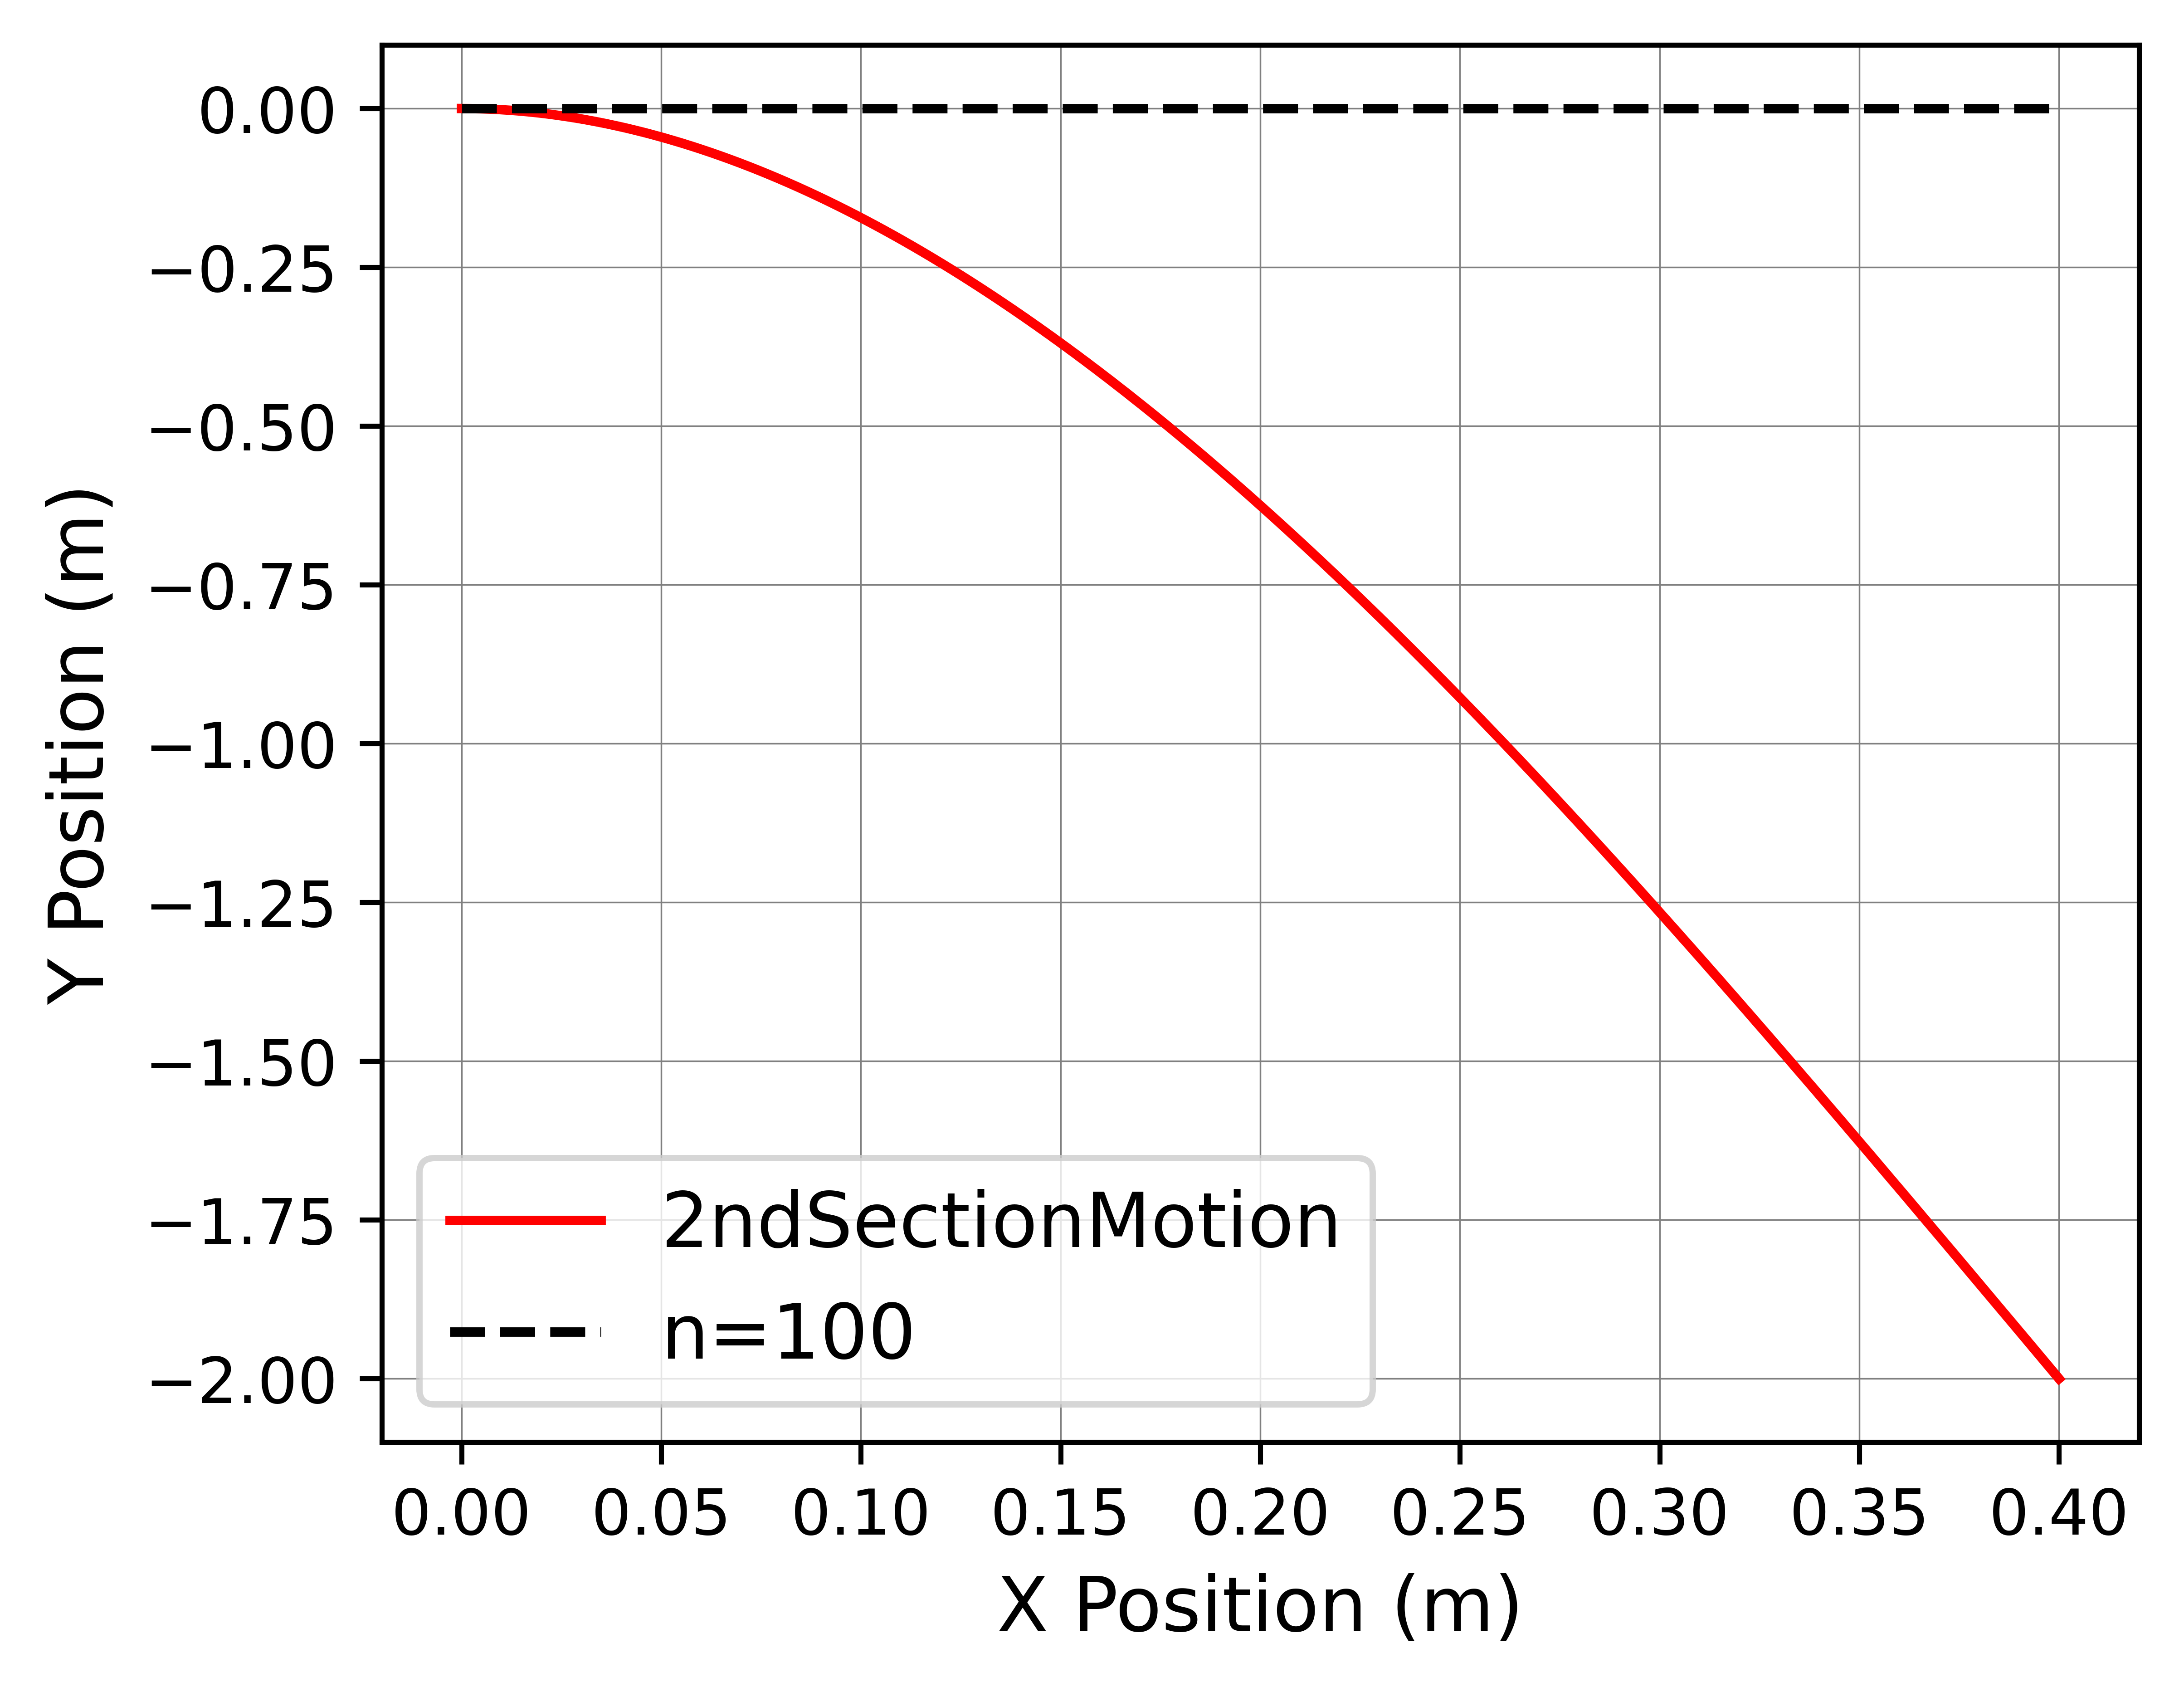

In [223]:
def plot_S2(rod2, uniform_force):
    import matplotlib.pyplot as plt

    rod_position = analytical_result(
        rod, uniform_force
    )
    rod2_position = analytical_result(
        rod2, uniform_force
    )

    fig = plt.figure(figsize=(5,4), frameon=True, dpi = 1000)
    ax = fig.add_subplot(111)
    ax.grid(which="major", color="grey", linestyle="-", linewidth=0.25)

    ax.plot(
        #rod_position[0],
        #rod_position[1],
        rod2_position[0],
        rod2_position[1],
        "r-",
        label="2ndSectionMotion",
    )

    ax.plot(
        rod.position_collection[2, :],
        rod.position_collection[0, :],
        #rod2.position_collection[2, :],
        #rod2.position_collection[0, :],
        "k--",
        label="n=" + str(rod.n_elems),
    )

    ax.legend(prop={"size": 12})
    ax.set_ylabel("Y Position (m)", fontsize=12)
    ax.set_xlabel("X Position (m)", fontsize=12)
    plt.show()

plot_S2(rod2, uniform_force)